In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import types
import sys, time, inspect

%matplotlib inline

In [2]:
# We define an iterator which gives the time taken for each step and which estimates the total time needed for the whole loop
def timeprint(Nb_iter=None,iterator=None):
    assert Nb_iter is not None or iterator is not None
    if Nb_iter is not None:
        iterator = np.arange(Nb_iter)
        times = []
        idx = 0
        for thing in iterator:
            prev_time = time.time()
            yield thing
            times.append(time.time() - prev_time)
            sys.stdout.write('Step {}/{} done in {:.4f}sec, ETA: {:.4f}sec   \r'.format(idx+1,Nb_iter,times[idx],np.mean(times)*(Nb_iter-idx+1)))
            idx += 1
            sys.stdout.flush()
            
    else:
        times = []
        idx = 0
        for thing in iterator:
            prev_time = time.time()
            yield thing
            times.append(time.time() - prev_time)
            sys.stdout.write('Step {} done in {:.4f}sec   \r'.format(idx,times[idx]))
            idx += 1
            sys.stdout.flush()
    print('\n{:.4f}sec avg, {:.4f}sec total\n'.format(np.mean(times),np.sum(times)))

### Basis functions

In [3]:
# We create a class for each basis. For each class we define all the functions that compose the basis

# Basis of functions given in Benjamin Van Roy paper
class Basis_Functions_BVR():
    def phi_1(x):
        return 1.

    def phi_2(x):
        return x[99]

    def phi_3(x):
        return np.min(x)-1.

    def phi_4(x):
        return np.max(x)-1.

    def phi_5(x):
        return (np.argmin(x)/50.) - 1.

    def phi_6(x):
        return (np.argmax(x)/50.) - 1.

    def phi_7(x):
        return np.sum((x-1.)/np.sqrt(2.))/100.

    def phi_8(x):
        j = np.arange(1,101)/50. - 1.
        return np.sum(x*np.sqrt(1.5)*j)/100.

    def phi_9(x):
        j = np.arange(1,101)/50. - 1.
        return np.sum(x*np.sqrt(2.5)*(1.5*j**2 - 0.5))/100.

    def phi_10(x):
        j = np.arange(1,101)/50. - 1.
        return np.sum(x*np.sqrt(3.5)*(2.5*j**3 - 1.5*j))/100.

    #def phi_11(x):
    #    return phi_2(x)*phi_3(x)

    #def phi_12(x):
    #    return phi_2(x)*phi_4(x)

    #def phi_13(x):
    #    return phi_2(x)*phi_7(x)

    #def phi_14(x):
    #    return phi_2(x)*phi_8(x)

    #def phi_15(x):
    #    return phi_2(x)*phi_9(x)

    #def phi_16(x):
    #    return phi_2(x)*phi_10(x)

class Basis_Functions_Fourier():
    def phi_1(x):
        return 1.

    def phi_2(x):
        return np.sqrt(2)*np.cos(2*np.pi*x[99])

    def phi_3(x):
        return np.sqrt(2)*np.sin(2*np.pi*x[99])

    def phi_4(x):
        return np.sqrt(2)*np.cos(2*np.pi*2*x[99])

    def phi_5(x):
        return np.sqrt(2)*np.sin(2*np.pi*2*x[99])

    def phi_6(x):
        return np.sqrt(2)*np.cos(2*np.pi*3*x[99])

    def phi_7(x):
        return np.sqrt(2)*np.sin(2*np.pi*3*x[99])

    def phi_8(x):
        return np.sqrt(2)*np.cos(2*np.pi*4*x[99])

    def phi_9(x):
        return np.sqrt(2)*np.sin(2*np.pi*4*x[99])
    
    def phi_10(x):
        return np.sqrt(2)*np.cos(2*np.pi*5*x[99])
    
# We store all the functions of each basis in a dictionnary     
basis_functions_dict = {}
for name, obj in inspect.getmembers(sys.modules[__name__]):
    if inspect.isclass(obj) and 'Basis_Functions' in name:
        basis_functions_dict[name] = [f for key, f in obj.__dict__.items() if type(f) == types.FunctionType]
        
#print(basis_functions_dict)

### Sampling the state process

In [4]:
# We define a class that samples the state process
class state_process:
    
    def __init__(self,rho=0.0004,sigma=0.02,initialization='standard'):
        self.rho = rho
        self.sigma = sigma
        
        self.N_matrix = np.triu(np.ones((100,100)))
        KK = np.arange(100,0,-1)
        self.Expterm1 = (rho - 0.5*sigma**2)*KK
        
        # We initialize with \tilde{p}_0 = 1
        if initialization == 'standard':
            self.Z_vec = np.random.normal(0,1,100).reshape(100,1)
            N_vec = np.dot(self.N_matrix,self.Z_vec)
            Expterm2 = sigma*N_vec.T

            self.X = np.fliplr(np.exp(self.Expterm1 + Expterm2))
            
        # We intialize with X_0 = (1, ... ,1)
        elif initialization == 'ones':
            self.Z_vec = (-np.linalg.solve(self.N_matrix,self.Expterm1.T)/self.sigma).reshape(100,1)
            N_vec = np.dot(self.N_matrix,self.Z_vec)
            Expterm2 = sigma*N_vec.T

            self.X = np.fliplr(np.exp(self.Expterm1 + Expterm2))
            
    def sample(self):
        self.Z_vec[1:,:] = self.Z_vec[:99,:]
        self.Z_vec[0,:] = np.random.normal(0,1)
        N_vec = np.dot(self.N_matrix,self.Z_vec)
        Expterm2 = self.sigma*N_vec.T
        
        self.X = np.fliplr(np.exp(self.Expterm1 + Expterm2))
        return self.X   

In [5]:
# This function samples states (for a given theta and basis functions) up until the optimal stopping time 
def sample_stopping_state(theta,basis='BVR'):
    # We select the basis functions
    phi = basis_functions_dict['Basis_Functions_'+basis]
    # We initialize time, state process, psi and Q
    i = 0
    SP = state_process(initialization='ones')
    Xt = SP.X
    
    psi_X = np.array([phi_i(Xt[0,:]) for phi_i in phi]).reshape(10,1)
    Q_theta = np.dot(theta.T,psi_X)

    while Xt[0,99] < Q_theta:
        Xt = SP.sample()
        
        psi_X = np.array([phi_i(Xt[0,:]) for phi_i in phi]).reshape(10,1)
        Q_theta = np.dot(theta.T,psi_X)
        
        i = i + 1
     
    # We return the optimal stopping time and the value of the state process at that time
    return i, Xt.T

### The algorithm

In [6]:
# We define a class that computes, using the Zap Qlearning algorithm, a theta given a number of steps
class Zap_Qlearning:
    
    def __init__(self,nb_steps,beta=np.exp(-0.0004),basis='BVR'):
        self.nb_theta = nb_steps//1000
        self.beta = beta
        self.nb_steps = nb_steps
        # We select the basis functions
        self.phi = basis_functions_dict['Basis_Functions_'+basis]
        # Initialization of the states
        self.SP = state_process()
        #self.Xt = np.zeros((self.nb_steps,100))
        #self.Xt[[0],:] = self.SP.X
        self.Xt = self.SP.X
        # Initialization of theta and A_hat
        self.n = 0
        self.theta_storage = np.zeros((10,self.nb_theta+1),dtype=np.double)
        self.theta = np.random.normal(0.,1.,10).reshape(10,1)
        self.theta_storage[:,[0]] = self.theta
        self.A_hat = 100.*np.eye(10,dtype=np.double)
        self.A_hat_BVR = 100.*np.eye(10,dtype=np.double)
        # Intialization of psi
        self.psi_next = np.array([phi_i(self.Xt[0,:]) for phi_i in self.phi]).reshape(10,1)
           
    def next_step(self):
        # We sample a new state
        #self.Xt[self.n+1,:] = self.SP.sample()
        self.Xt = self.SP.sample()
        # We update the reward and the two time scales
        reward = self.Xt[0,99]
        alpha = 1./(self.n + 1.)
        gamma = np.power(alpha,0.85)
        # We update psi. Current is for psi(X_n) and next is for psi(X_{n+1})
        psi_current = self.psi_next 
        self.psi_next = np.array([phi_i(self.Xt[0,:]) for phi_i in self.phi]).reshape(10,1)
        # We compute Q^{theta_n}(X_n) (current) and Q^{theta_n}(X_{n+1}) (next)
        Q_current = np.dot(self.theta.T,psi_current)
        Q_next = np.dot(self.theta.T,self.psi_next)
        
        # We compute varphi
        #varphi = self.beta * self.psi_next - psi_current if Q_next >= reward else -psi_current
        varphi = psi_current - self.beta * self.psi_next if Q_next >= reward else psi_current
        
        # We compute A
        self.A = np.dot(psi_current,varphi.T)
        
        # We update the estimator A_hat for the SNR and the BVR algorithms
        self.A_hat = self.A_hat + gamma * (self.A - self.A_hat)
        self.A_hat_BVR = self.A_hat_BVR + alpha * (np.dot(psi_current,psi_current.T) - self.A_hat_BVR)
        
        # We try to invert the estimator A_hat for the SNR. If it fails we invert the estimator A_hat for the BVR
        try:
            G = np.linalg.inv(self.A_hat)
        except np.linalg.linalg.LinAlgError as err:
            G = 200.*np.linalg.inv(self.A_hat_BVR)

        # We update theta
        self.theta = self.theta + alpha * np.dot(G,psi_current)*(self.beta*np.maximum(reward,Q_next)-Q_current)
        
        self.n = self.n + 1
        
        if n%1000==0:
            self.theta_storage[:,[n//1000]] = self.theta
        
    def fit(self):
        for i in timeprint(self.nb_steps-1):
            self.next_step()

### Discounted rewards

In [9]:
N = 100 # Number of samples for the histogram of the discounted rewards
K = 1000 # Number of samples for the Monte-Carlo estimation of each discounted reward
k = 4
n = 2 * 10**k
beta = np.exp(-0.0004)
h_hat = np.zeros(N)
for i in timeprint(N):
    # We sample a theta
    algo = Zap_Qlearning(n)
    algo.fit()
    # We estimate the discounted reward for this theta with Monte-Carlo estimation
    for _ in np.arange(K):
        # We sample the optimal stopping time and the value of the state process at that time
        tau, X_tau = sample_stopping_state(algo.theta[:,n-1])
        h_hat[i] = h_hat[i] + np.power(beta,tau)*X_tau[99]
    h_hat[i] = h_hat[i] / K

LinAlgError: Singular matrix

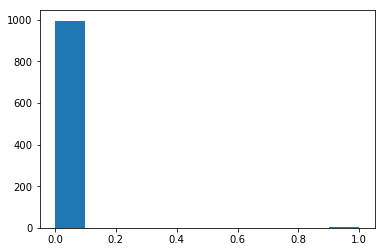

In [32]:
plt.hist(h_hat);

### Theta trace

In [9]:
algo.theta_storage[0,:10]

array([-1.63466881,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [7]:
k = 4
n = 2 * 10**k
algo = Zap_Qlearning(n)

algo.fit()



0.0005sec avg, 10.3481sec total



In [8]:
k = 4
n = 2 * 10**k
algo = Zap_Qlearning(n)

algo.fit()



0.0005sec avg, 10.3341sec total



In [10]:
algo.theta

array([[   265.06009018],
       [ 49532.27406338],
       [ -3996.86889335],
       [ 29485.79912814],
       [ -9962.19922698],
       [-77963.49258314],
       [ -4010.77809946],
       [ 15318.18069277],
       [-29214.91241155],
       [ 43950.91609921]])

In [9]:
algo.theta_storage

array([[  7.63280370e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.65060090e+02],
       [  1.99511209e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.95322741e+04],
       [  1.84156959e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
      

In [7]:
k = 6
n = 2 * 10**k
algo = Zap_Qlearning(n)

algo.fit()

fig, ax = plt.subplots(1,1,figsize=(15,5))
for i in range(10):
    ax.plot(algo.theta_storage[i,:],label="theta({})".format(i))
ax.set_yscale('symlog')
ax.legend(loc='best');

KeyboardInterrupt: 

### CLT

In [48]:
import sys
import time

In [51]:
k = 4
n = 2 * 10**k
N = 100
theta_list = np.zeros((10,N),dtype=np.double)
for i in timeprint(N):
    algo = Zap_Qlearning(n)
    algo.fit()
    theta_list[:,i] = algo.theta[:,n-1].flatten()
    #sys.stdout.write("step: {0}/{1} done  \s".format(i+1,N))
    #sys.stdout.flush()
theta_bar = theta_list.mean(axis=0)
W = np.sqrt(n)*(theta_list - theta_bar)

LinAlgError: Singular matrix

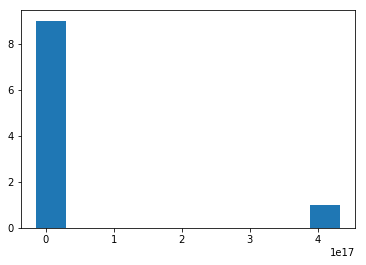

In [57]:
plt.hist(W[6,:]);

In [58]:
W[6,:]

array([ -4.24521743e+12,   4.32939572e+17,   2.72080705e+04,
        -1.43164459e+16,   2.10032457e+06,  -2.82117931e+04,
         4.11258566e+04,   3.20609177e+12,  -1.90668094e+14,
         8.50851591e+05])

### A eigenvalues

In [103]:
n = 2*10**6
start = time.time()
X = sample_last_states(n,1.,1.)
print(time.time()-start)

2.3233020305633545


In [115]:
n = 2*10**6
start = time.time()
X = sample_last_states_direct(n,1.,1.)
print(time.time()-start)

0.146256685256958


In [126]:
n = 2*10**6
N = 1000
beta = 0.8
algo = Zap_Qlearning(n)
algo.fit()
theta = algo.theta
A = np.zeros((10,10))
for i in timeprint(N):
    X = sample_last_states_direct(n+1,1.,1.)
    psi_current = np.array([phi_i(X[:,0].T) for phi_i in phi]).reshape(10,1)
    psi_next = np.array([phi_i(X[:,1].T) for phi_i in phi]).reshape(10,1)
    reward = X[99,1]
    Q_X_next = np.dot(theta.T,psi_next)
    varphi = beta * psi_next - psi_current if Q_X_next >= reward else -psi_current    
    A = A + np.dot(psi_current,varphi.T)
    
A = A / N

Step 1000/1000 done in 0.1219sec, ETA: 0.2437sec    
0.1219sec avg, 121.8569sec total



In [129]:
eigval, eigvec = np.linalg.eig(A)

In [135]:
eigval

array([ -2.89459512e+00,  -6.20486248e-01,  -6.77832604e-02,
        -1.53144633e-02,  -2.97782552e-03,  -1.60267384e-03,
        -3.28433884e-04,  -2.45647695e-04,  -3.59236222e-05,
        -6.52740101e-05])

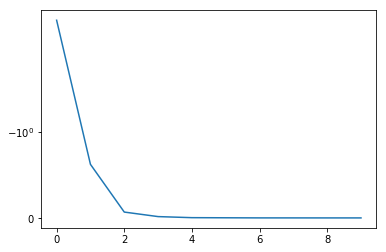

In [134]:
fig, ax = plt.subplots(1,1)
ax.plot(eigval)
ax.set_yscale('symlog')
plt.gca().invert_yaxis();